In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import unary_union
import pandas as pd
from typing import List, Tuple, Optional

class PlotSimulation:
    def __init__(self, width: float = 10.0, height: float = 10.0, n_plants: int = 20,
                 distribution: str = 'random', distribution_params: dict = None,
                 detection_params: dict = None):
        """Initialize plot simulation with customizable parameters"""
        self.width = width
        self.height = height
        self.n_plants = n_plants
        self.distribution = distribution
        self.distribution_params = distribution_params or {}
        
        if detection_params is None:
            self.detection_params = {'fixed': 0.2}
        elif isinstance(detection_params, (int, float)):
            self.detection_params = {'fixed': float(detection_params)}
        else:
            self.detection_params = detection_params
            
        self.plants = self._generate_plants()
        self.plant_buffers = self._create_plant_buffers()

    # [Previous PlotSimulation methods remain the same]
    def _generate_plants(self) -> List[Point]:
        """Generate plant locations based on specified distribution."""
        if self.distribution == 'random':
            return self._generate_random_plants()
        elif self.distribution == 'clustered':
            return self._generate_clustered_plants()
        elif self.distribution == 'regular':
            return self._generate_regular_plants()
        elif self.distribution == 'gradient':
            return self._generate_gradient_plants()
        else:
            raise ValueError(f"Unknown distribution type: {self.distribution}")
    
    def _generate_random_plants(self) -> List[Point]:
        """Generate completely random plant locations."""
        x_coords = np.random.uniform(0, self.width, self.n_plants)
        y_coords = np.random.uniform(0, self.height, self.n_plants)
        return [Point(x, y) for x, y in zip(x_coords, y_coords)]
    
    def _generate_clustered_plants(self) -> List[Point]:
        """Generate clustered plant distribution using Gaussian clusters."""
        n_clusters = self.distribution_params.get('n_clusters', 3)
        cluster_std = self.distribution_params.get('cluster_std', 1.0)
        
        cluster_centers_x = np.random.uniform(cluster_std, self.width - cluster_std, n_clusters)
        cluster_centers_y = np.random.uniform(cluster_std, self.height - cluster_std, n_clusters)
        
        points = []
        plants_per_cluster = self.n_plants // n_clusters
        remaining_plants = self.n_plants % n_clusters
        
        for i in range(n_clusters):
            n_plants_this_cluster = plants_per_cluster + (1 if i < remaining_plants else 0)
            x_coords = np.random.normal(cluster_centers_x[i], cluster_std, n_plants_this_cluster)
            y_coords = np.random.normal(cluster_centers_y[i], cluster_std, n_plants_this_cluster)
            x_coords = np.clip(x_coords, 0, self.width)
            y_coords = np.clip(y_coords, 0, self.height)
            points.extend([Point(x, y) for x, y in zip(x_coords, y_coords)])
        return points
    
    def _generate_regular_plants(self) -> List[Point]:
        """Generate regularly spaced plants with optional jitter."""
        jitter = self.distribution_params.get('jitter', 0.2)
        n_rows = int(np.sqrt(self.n_plants * self.height / self.width))
        n_cols = int(np.sqrt(self.n_plants * self.width / self.height))
        row_spacing = self.height / (n_rows + 1)
        col_spacing = self.width / (n_cols + 1)
        
        points = []
        for i in range(1, n_rows + 1):
            for j in range(1, n_cols + 1):
                if len(points) < self.n_plants:
                    x = j * col_spacing + np.random.uniform(-jitter, jitter)
                    y = i * row_spacing + np.random.uniform(-jitter, jitter)
                    x = np.clip(x, 0, self.width)
                    y = np.clip(y, 0, self.height)
                    points.append(Point(x, y))
        return points
    
    def _generate_gradient_plants(self) -> List[Point]:
        """Generate plants with density following a gradient."""
        direction = self.distribution_params.get('direction', 'x')
        steepness = self.distribution_params.get('steepness', 1.0)
        
        points = []
        while len(points) < self.n_plants:
            x = np.random.uniform(0, self.width)
            y = np.random.uniform(0, self.height)
            
            if direction == 'x':
                prob = np.exp(-steepness * x / self.width)
            elif direction == 'y':
                prob = np.exp(-steepness * y / self.height)
            else:
                prob = np.exp(-steepness * (x + y) / (self.width + self.height))
                
            if np.random.random() < prob:
                points.append(Point(x, y))
        return points
    
    def _create_plant_buffers(self):
        """Create detection buffers around plants with variable radii."""
        if 'fixed' in self.detection_params:
            radius = self.detection_params['fixed']
            return [plant.buffer(radius) for plant in self.plants]
            
        dist_type = self.detection_params.get('distribution', 'uniform')
        params = self.detection_params.get('params', {})
        
        if dist_type == 'uniform':
            min_r = params.get('min', 0.1)
            max_r = params.get('max', 0.3)
            radii = np.random.uniform(min_r, max_r, self.n_plants)
        elif dist_type == 'normal':
            mean = params.get('mean', 0.2)
            std = params.get('std', 0.05)
            radii = np.clip(np.random.normal(mean, std, self.n_plants), 0.01, None)
        elif dist_type == 'lognormal':
            mean = params.get('mean', -2)
            std = params.get('std', 0.5)
            radii = np.exp(np.random.normal(mean, std, self.n_plants))
        else:
            raise ValueError(f"Unknown detection radius distribution: {dist_type}")
            
        return [plant.buffer(radius) for plant, radius in zip(self.plants, radii)]
    
    def zigzag_path(self, angle_degrees: float = 0, spacing: float = 2.0) -> LineString:
        """Generate a zig-zag search path rotated by a specified angle."""
        angle = np.radians(angle_degrees)
        n_traverses = max(2, int(np.ceil(self.height / spacing)) + 1)
        points = []
        
        for i in range(n_traverses):
            y = i * spacing
            if i % 2 == 0:
                points.extend([(0, y), (self.width, y)])
            else:
                points.extend([(self.width, y), (0, y)])
        
        center_x, center_y = self.width/2, self.height/2
        rotated_points = []
        
        for x, y in points:
            tx = x - center_x
            ty = y - center_y
            rx = tx * np.cos(angle) - ty * np.sin(angle)
            ry = tx * np.sin(angle) + ty * np.cos(angle)
            rotated_points.append((rx + center_x, ry + center_y))
                    
        return LineString(rotated_points)
    
    def parallel_path(self, spacing: float = 2.0) -> LineString:
        """Generate parallel line search path."""
        n_traverses = max(2, int(np.ceil(self.height / spacing)) + 1)
        points = []
        
        for i in range(n_traverses):
            y = i * spacing
            if y <= self.height:
                points.extend([(0, y), (self.width, y)])
        
        return LineString(points)
    
    def evaluate_path(self, path: LineString) -> Tuple[int, float, List[Point]]:
        """Evaluate a search path."""
        plant_union = unary_union(self.plant_buffers)
        intersection = path.intersection(plant_union)
        
        found_plants = []
        for plant, buffer in zip(self.plants, self.plant_buffers):
            if path.intersects(buffer):
                found_plants.append(plant)
                
        return len(found_plants), path.length, found_plants
    
    def plot_simulation(self, path: Optional[LineString] = None, found_plants: Optional[List[Point]] = None):
        """Visualize the plot, plants, and search path."""
        fig, ax = plt.subplots(figsize=(10, 10))
        
        for plant, buffer in zip(self.plants, self.plant_buffers):
            ax.plot(plant.x, plant.y, 'g.')
            x, y = buffer.exterior.xy
            ax.plot(x, y, 'g--', alpha=0.3)
            
        if found_plants:
            for plant in found_plants:
                ax.plot(plant.x, plant.y, 'r*', markersize=10)
        
        if path:
            x, y = path.xy
            ax.plot(x, y, 'b-', label='Search Path')
            
        ax.set_xlim(-0.5, self.width + 0.5)
        ax.set_ylim(-0.5, self.height + 0.5)
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_title(f'Plot Simulation ({self.width}m x {self.height}m)')
        ax.set_xlabel('Width (m)')
        ax.set_ylabel('Height (m)')
        plt.legend()
        plt.show()


class SearchOptimization:
    def __init__(self, plot_params: dict):
        """Initialize search pattern optimization."""
        self.plot_params = plot_params
        self.results = []
        
    def run_parameter_sweep(self, 
                          n_trials: int = 5,
                          spacings: List[float] = [0.5, 1.0, 1.5, 2.0, 2.5],
                          angles: List[float] = [0, 15, 30, 45, 60]):
        """Run systematic tests of different search parameters."""
        for trial in range(n_trials):
            sim = PlotSimulation(**self.plot_params)
            n_total_plants = sim.n_plants
            
            # Test parallel paths
            for spacing in spacings:
                path = sim.parallel_path(spacing=spacing)
                n_found, path_length, _ = sim.evaluate_path(path)
                
                self.results.append({
                    'trial': trial,
                    'pattern': 'parallel',
                    'spacing': spacing,
                    'angle': None,
                    'n_found': n_found,
                    'n_total': n_total_plants,
                    'detection_rate': n_found / n_total_plants,
                    'path_length': path_length,
                    'efficiency': n_found / path_length if path_length > 0 else 0
                })
            
            # Test zigzag paths
            for spacing in spacings:
                for angle in angles:
                    path = sim.zigzag_path(spacing=spacing, angle_degrees=angle)
                    n_found, path_length, _ = sim.evaluate_path(path)
                    
                    self.results.append({
                        'trial': trial,
                        'pattern': 'zigzag',
                        'spacing': spacing,
                        'angle': angle,
                        'n_found': n_found,
                        'n_total': n_total_plants,
                        'detection_rate': n_found / n_total_plants,
                        'path_length': path_length,
                        'efficiency': n_found / path_length if path_length > 0 else 0
                    })
    
    def analyze_results(self):
        """Analyze and summarize parameter sweep results."""
        df = pd.DataFrame(self.results)
        
        parallel_summary = df[df['pattern'] == 'parallel'].groupby('spacing').agg({
            'detection_rate': ['mean', 'std'],
            'path_length': ['mean', 'std'],
            'efficiency': ['mean', 'std']
        })
        
        zigzag_summary = df[df['pattern'] == 'zigzag'].groupby(['spacing', 'angle']).agg({
            'detection_rate': ['mean', 'std'],
            'path_length': ['mean', 'std'],
            'efficiency': ['mean', 'std']
        })
        
        best_parallel = parallel_summary['detection_rate']['mean'].idxmax()
        best_zigzag = zigzag_summary['detection_rate']['mean'].idxmax()
        
        return {
            'parallel_summary': parallel_summary,
            'zigzag_summary': zigzag_summary,
            'best_parallel_spacing': best_parallel,
            'best_zigzag_params': best_zigzag,
            'full_results': df
        }
    
    def analyze_marginal_returns(self, min_improvement: float = 0.02):
        """Analyze marginal returns for spacing values."""
        df = pd.DataFrame(self.results)
        
        def find_optimal_spacing(pattern_data):
            spacing_results = pattern_data.groupby('spacing')['detection_rate'].mean()
            spacings = sorted(spacing_results.index)
            
            marginal_improvements = []
            detection_rates = []
            
            for i in range(len(spacings)):
                rate = spacing_results[spacings[i]]
                detection_rates.append(rate)
                
                if i > 0:
                    improvement = rate - spacing_results[spacings[i-1]]
                    marginal_improvements.append(improvement)
                
            optimal_idx = 0
            for i in range(len(marginal_improvements)):
                if marginal_improvements[i] < min_improvement:
                    optimal_idx = i
                    break
                    
            return {
                'optimal_spacing': spacings[optimal_idx],
                'detection_rate': detection_rates[optimal_idx],
                'spacings': spacings,
                'detection_rates': detection_rates,
                'marginal_improvements': marginal_improvements
            }
        
        parallel_data = df[df['pattern'] == 'parallel']
        parallel_analysis = find_optimal_spacing(parallel_data)
        
        zigzag_data = df[df['pattern'] == 'zigzag']
        zigzag_by_angle = {}
        
        for angle in zigzag_data['angle'].unique():
            angle_data = zigzag_data[zigzag_data['angle'] == angle]
            zigzag_by_angle[angle] = find_optimal_spacing(angle_data)
        
        return {
            'parallel': parallel_analysis,
            'zigzag': zigzag_by_angle
        }
    
    def plot_marginal_analysis(self):
        """Plot marginal returns analysis."""
        analysis = self.analyze_marginal_returns()
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot parallel pattern analysis
        parallel = analysis['parallel']
        ax1.plot(parallel['spacings'], parallel['detection_rates'], 'bo-')
        ax1.axvline(x=parallel['optimal_spacing'], color='r', linestyle='--')
        ax1.set_title('Parallel Pattern: Detection Rate vs Spacing')
        ax1.set_xlabel('Spacing (m)')
        ax1.set_ylabel('Detection Rate')
        ax1.grid(True)
        
        # Plot zigzag pattern analysis for each angle
        for angle, data in analysis['zigzag'].items():
            ax2.plot(data['spacings'], data['detection_rates'], 
                    'o-', label=f'Angle: {angle}°')
            ax2.axvline(x=data['optimal_spacing'], 
                       linestyle='--', alpha=0.3)
        
        ax2.set_title('Zigzag Pattern: Detection Rate vs Spacing')
        ax2.set_xlabel('Spacing (m)')
        ax2.set_ylabel('Detection Rate')
        ax2.grid(True)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed analysis
        print("\nOptimal Spacing Analysis:")
        print("\nParallel Pattern:")
        print(f"Optimal spacing: {parallel['optimal_spacing']:.2f}m")
        print(f"Detection rate at optimal spacing: {parallel['detection_rate']:.2%}")
        
        print("\nZigzag Pattern:")
        for angle, data in analysis['zigzag'].items():
            print(f"\nAngle: {angle}°")
            print(f"Optimal spacing: {data['optimal_spacing']:.2f}m")
            print(f"Detection rate at optimal spacing: {data['detection_rate']:.2%}")
    
    def plot_best_patterns(self):
        """Plot examples of the best-performing patterns."""
        results = self.analyze_results()
        sim = PlotSimulation(**self.plot_params)
        
        # Plot best parallel pattern
        best_parallel = sim.parallel_path(spacing=results['best_parallel_spacing'])
        n_found, path_length, found_plants = sim.evaluate_path(best_parallel)
        print(f"\nBest Parallel Pattern (spacing={results['best_parallel_spacing']:.1f}m):")
        print(f"Detection Rate: {n_found/sim.n_plants:.2%}")
        print(f"Path Length: {path_length:.1f}m")
        sim.plot_simulation(best_parallel, found_plants)
        
        # Plot best zigzag pattern
        best_spacing, best_angle = results['best_zigzag_params']
        best_zigzag = sim.zigzag_path(spacing=best_spacing, angle_degrees=best_angle)
        n_found, path_length, found_plants = sim.evaluate_path(best_zigzag)
        print(f"\nBest Zigzag Pattern (spacing={best_spacing:.1f}m, angle={best_angle}°):")
        print(f"Detection Rate: {n_found/sim.n_plants:.2%}")
        print(f"Path Length: {path_length:.1f}m")
        sim.plot_simulation(best_zigzag, found_plants)
        
    @staticmethod
    def run_distribution_comparison(n_trials: int = 5,
                                  spacings: List[float] = [0.5, 1.0, 1.5, 2.0, 2.5],
                                  angles: List[float] = [0, 15, 30, 45]):
        """
        Compare different distribution types with various search patterns.
        
        Args:
            n_trials: Number of trials per configuration
            spacings: List of spacing values to test
            angles: List of angles to test for zigzag patterns
        """
        # Define distributions to test
        distributions = {
            'random': {
                'distribution': 'random',
                'detection_params': {'fixed': 0.2}
            },
            'clustered': {
                'distribution': 'clustered',
                'distribution_params': {'n_clusters': 3, 'cluster_std': 1.0},
                'detection_params': {'fixed': 0.2}
            },
            'regular': {
                'distribution': 'regular',
                'distribution_params': {'jitter': 0.3},
                'detection_params': {'fixed': 0.2}
            },
            'gradient': {
                'distribution': 'gradient',
                'distribution_params': {'direction': 'x', 'steepness': 2.0},
                'detection_params': {'fixed': 0.2}
            }
        }
        
        # Store results for each distribution
        all_results = {}
        
        for dist_name, dist_params in distributions.items():
            print(f"\nTesting {dist_name} distribution...")
            optimizer = SearchOptimization({
                'n_plants': 30,
                **dist_params
            })
            
            optimizer.run_parameter_sweep(n_trials, spacings, angles)
            all_results[dist_name] = optimizer.results
        
        return all_results

    @staticmethod
    def plot_distribution_comparison(all_results, min_improvement: float = 0.02):
        """
        Plot comparison of detection rates across different distributions.
        
        Args:
            all_results: Dictionary of results from different distributions
            min_improvement: Threshold for marginal improvements
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Colors for different distributions
        colors = {'random': 'blue', 'clustered': 'red', 
                 'regular': 'green', 'gradient': 'purple'}
        
        # Plot parallel patterns
        for dist_name, results in all_results.items():
            df = pd.DataFrame(results)
            parallel_data = df[df['pattern'] == 'parallel']
            
            # Calculate mean detection rate for each spacing
            mean_rates = parallel_data.groupby('spacing')['detection_rate'].mean()
            spacings = sorted(mean_rates.index)
            rates = [mean_rates[s] for s in spacings]
            
            ax1.plot(spacings, rates, 'o-', 
                    label=f'{dist_name.capitalize()}',
                    color=colors[dist_name])
        
        ax1.set_title('Parallel Pattern: Detection Rate by Distribution')
        ax1.set_xlabel('Spacing (m)')
        ax1.set_ylabel('Detection Rate')
        ax1.grid(True)
        ax1.legend()
        
        # Plot zigzag patterns (using best angle for each distribution)
        for dist_name, results in all_results.items():
            df = pd.DataFrame(results)
            zigzag_data = df[df['pattern'] == 'zigzag']
            
            # Find best angle for this distribution
            angle_performance = zigzag_data.groupby('angle')['detection_rate'].mean()
            best_angle = angle_performance.idxmax()
            
            # Get data for best angle
            best_angle_data = zigzag_data[zigzag_data['angle'] == best_angle]
            mean_rates = best_angle_data.groupby('spacing')['detection_rate'].mean()
            spacings = sorted(mean_rates.index)
            rates = [mean_rates[s] for s in spacings]
            
            ax2.plot(spacings, rates, 'o-',
                    label=f'{dist_name.capitalize()} (angle={best_angle}°)',
                    color=colors[dist_name])
        
        ax2.set_title('Zigzag Pattern: Detection Rate by Distribution')
        ax2.set_xlabel('Spacing (m)')
        ax2.set_ylabel('Detection Rate')
        ax2.grid(True)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print optimal spacings for each distribution
        print("\nOptimal Spacing Analysis by Distribution:")
        for dist_name, results in all_results.items():
            df = pd.DataFrame(results)
            print(f"\n{dist_name.capitalize()} Distribution:")
            
            # Analyze parallel pattern
            parallel_data = df[df['pattern'] == 'parallel']
            parallel_rates = parallel_data.groupby('spacing')['detection_rate'].mean()
            best_parallel_spacing = parallel_rates.idxmax()
            
            print(f"Parallel pattern optimal spacing: {best_parallel_spacing:.2f}m")
            print(f"Maximum detection rate: {parallel_rates.max():.2%}")
            
            # Analyze zigzag pattern
            zigzag_data = df[df['pattern'] == 'zigzag']
            zigzag_rates = zigzag_data.groupby(['angle', 'spacing'])['detection_rate'].mean()
            best_angle, best_spacing = zigzag_rates.idxmax()
            
            print(f"Zigzag pattern optimal configuration:")
            print(f"  Spacing: {best_spacing:.2f}m")
            print(f"  Angle: {best_angle}°")
            print(f"Maximum detection rate: {zigzag_rates.max():.2%}")

Running distribution comparison...

Testing random distribution...

Testing clustered distribution...

Testing regular distribution...

Testing gradient distribution...

Plotting distribution comparison...


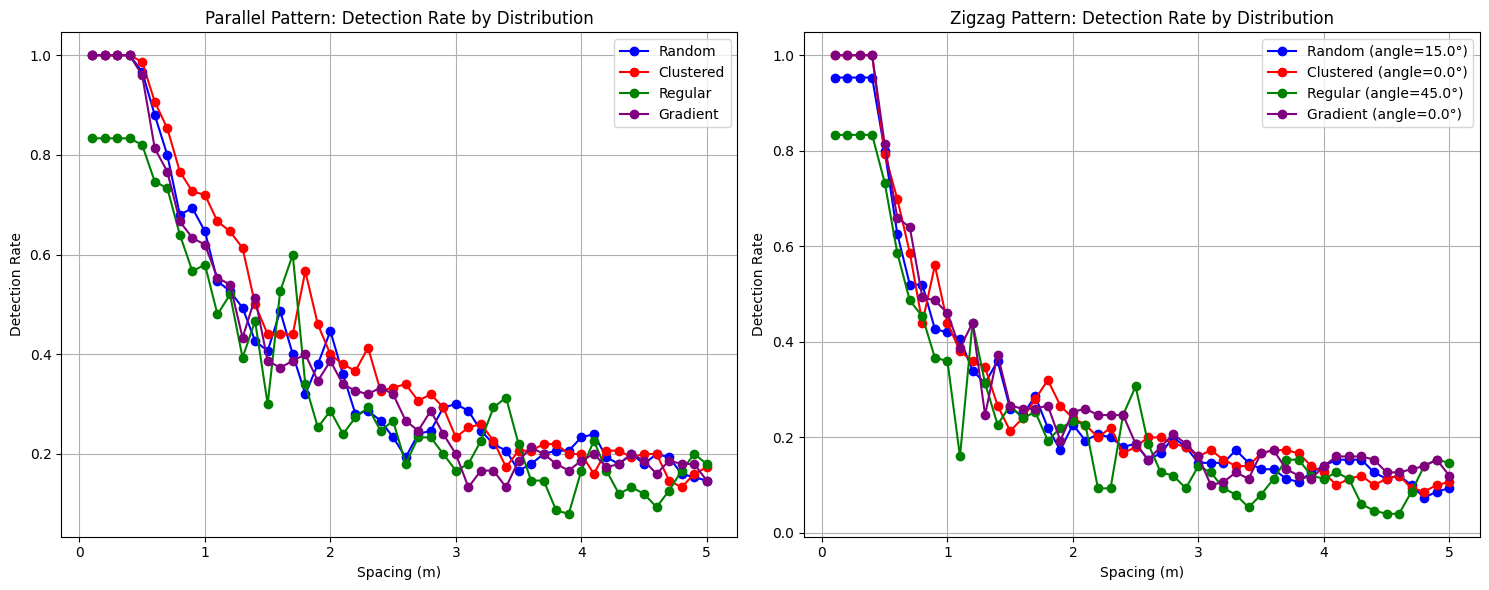


Optimal Spacing Analysis by Distribution:

Random Distribution:
Parallel pattern optimal spacing: 0.10m
Maximum detection rate: 100.00%
Zigzag pattern optimal configuration:
  Spacing: 0.10m
  Angle: 0.0°
Maximum detection rate: 100.00%

Clustered Distribution:
Parallel pattern optimal spacing: 0.10m
Maximum detection rate: 100.00%
Zigzag pattern optimal configuration:
  Spacing: 0.10m
  Angle: 0.0°
Maximum detection rate: 100.00%

Regular Distribution:
Parallel pattern optimal spacing: 0.10m
Maximum detection rate: 83.33%
Zigzag pattern optimal configuration:
  Spacing: 0.10m
  Angle: 0.0°
Maximum detection rate: 83.33%

Gradient Distribution:
Parallel pattern optimal spacing: 0.10m
Maximum detection rate: 100.00%
Zigzag pattern optimal configuration:
  Spacing: 0.10m
  Angle: 0.0°
Maximum detection rate: 100.00%

Running single distribution analysis...


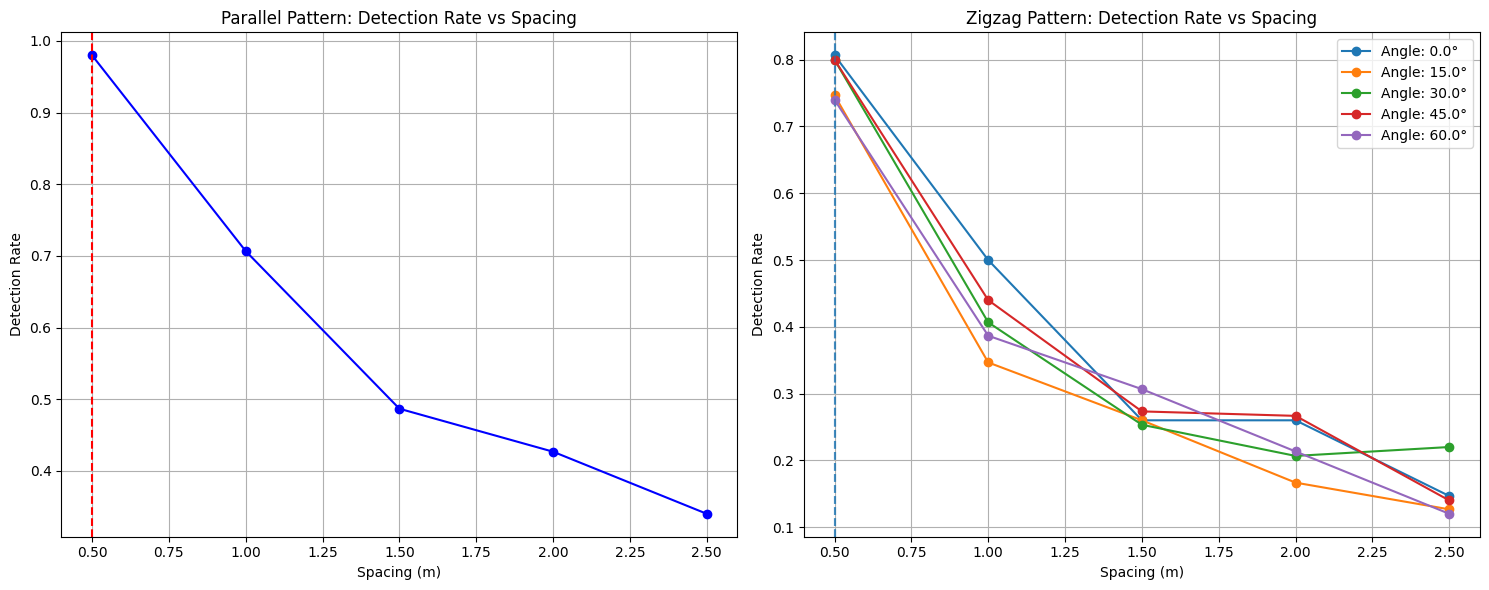


Optimal Spacing Analysis:

Parallel Pattern:
Optimal spacing: 0.50m
Detection rate at optimal spacing: 98.00%

Zigzag Pattern:

Angle: 0.0°
Optimal spacing: 0.50m
Detection rate at optimal spacing: 80.67%

Angle: 15.0°
Optimal spacing: 0.50m
Detection rate at optimal spacing: 74.67%

Angle: 30.0°
Optimal spacing: 0.50m
Detection rate at optimal spacing: 80.00%

Angle: 45.0°
Optimal spacing: 0.50m
Detection rate at optimal spacing: 80.00%

Angle: 60.0°
Optimal spacing: 0.50m
Detection rate at optimal spacing: 74.00%

Best Parallel Pattern (spacing=0.5m):
Detection Rate: 96.67%
Path Length: 410.2m


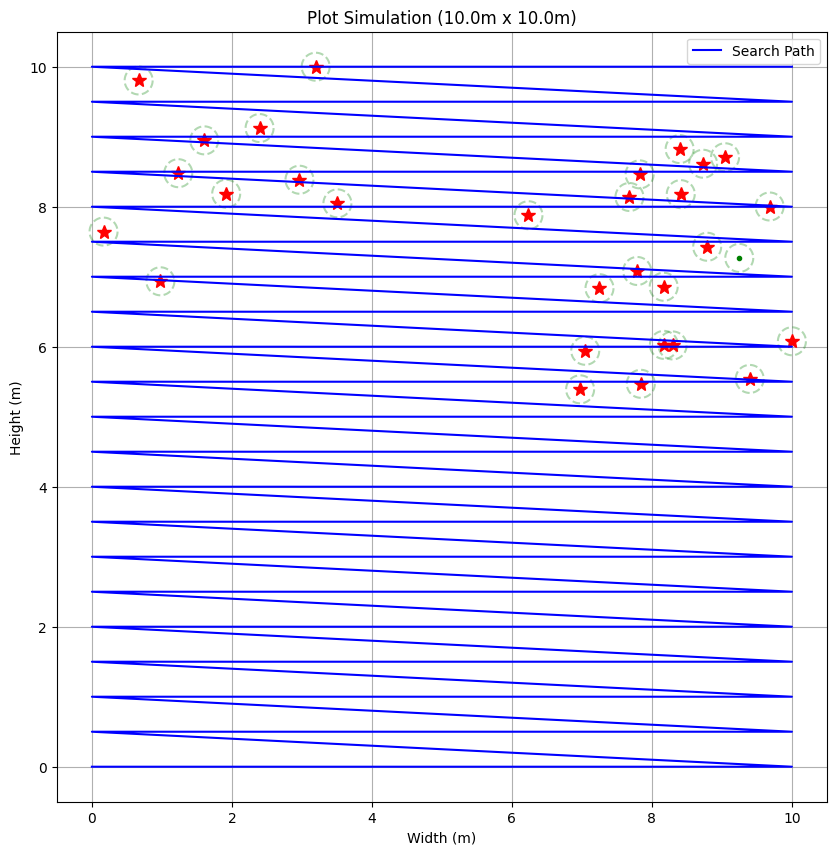


Best Zigzag Pattern (spacing=0.5m, angle=0.0°):
Detection Rate: 93.33%
Path Length: 220.0m


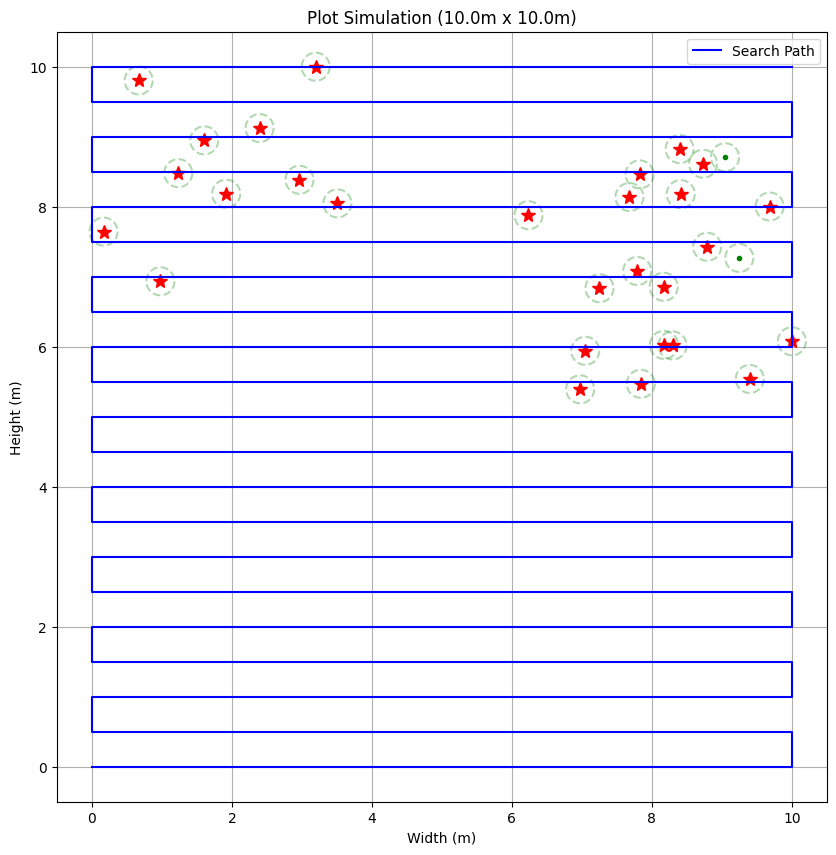

In [3]:
# Run distribution comparison
print("Running distribution comparison...")
results = SearchOptimization.run_distribution_comparison(
    n_trials=5,
    spacings=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0],
    angles=[0, 15, 30, 45]
)

# Plot comparison results
print("\nPlotting distribution comparison...")
SearchOptimization.plot_distribution_comparison(results)

# Example of single distribution analysis
print("\nRunning single distribution analysis...")
optimizer = SearchOptimization({
    'n_plants': 30,
    'distribution': 'clustered',
    'distribution_params': {'n_clusters': 3, 'cluster_std': 1.0},
    'detection_params': {'fixed': 0.2}
})

optimizer.run_parameter_sweep()
optimizer.plot_marginal_analysis()
optimizer.plot_best_patterns()